# Install Transformers Library

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# specify GPU
device = torch.device("cuda")

# Load Dataset

In [2]:
df = pd.read_csv("data/spamdata_v2.csv")#pd.read_csv("movie_data.csv", names=['text', 'label'], header=0).sample(100)#("spamdata_v2.csv")#.sample(1000)
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
# check class distribution
df['label'].value_counts(normalize = True)

label
0    0.865937
1    0.134063
Name: proportion, dtype: float64

In [4]:
label_mapping = {0: 'Not Spam', 1: 'Spam'}

# Split train dataset into train, validation and test sets

In [5]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'], 
                                                                    random_state=42, 
                                                                    test_size=0.10, 
                                                                    stratify=df['label'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=42, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

del temp_text, temp_labels

# Import BERT Model and BERT Tokenizer

In [6]:
import transformers
from transformers import AutoModel, BertTokenizerFast

# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

C:\Users\tonba\miniconda3\envs\MLprojects\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
!pip install datetime

In [8]:
from datetime import datetime

# EDA 

In [9]:
# Get the sequence length of the dataset
df['sequence_length'] = df['text'].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=True)))

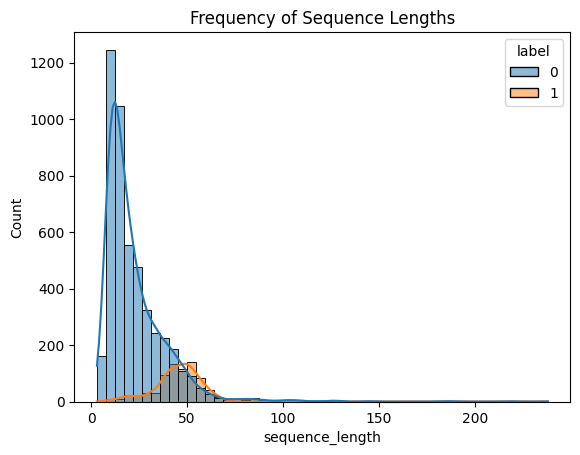

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(data=df, x="sequence_length", kde=True, hue='label', bins=50)
plt.title('Frequency of Sequence Lengths')
plt.show()

# Tokenization

In [11]:
max_seq_len = 75

# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
                                        train_text.tolist(),
                                        max_length = max_seq_len,
                                        pad_to_max_length=True,
                                        truncation=True,
                                        return_token_type_ids=False
                                    )

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
                                        val_text.tolist(),
                                        max_length = max_seq_len,
                                        pad_to_max_length=True,
                                        truncation=True,
                                        return_token_type_ids=False
                                    )

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
                                        test_text.tolist(),
                                        max_length = max_seq_len,
                                        pad_to_max_length=True,
                                        truncation=True,
                                        return_token_type_ids=False
                                    )

C:\Users\tonba\miniconda3\envs\MLprojects\Lib\site-packages\transformers\tokenization_utils_base.py:2618: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


# Convert Integer Sequences to Tensors

In [12]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

# Create DataLoaders

In [13]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 128

### Training data
# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)


### Validation set
# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# Define Model Architecture

In [14]:
class BERT_Arch(nn.Module):
    def __init__(self, bert, freeze_bert=True):
        super(BERT_Arch, self).__init__()

        # Base BERT model
        self.bert = bert 
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
        
        # relu activation function
        self.relu =  nn.ReLU()
        
        # dense layer 1
        self.fc1 = nn.Linear(768, 512)
        
        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512, 1)

        if freeze_bert:
            # Freeze all the parameters in the BERT model
            for param in self.bert.parameters():
                param.requires_grad = False

            # Unfreeze the parameters in the last layer (BertPooler) of the BERT model
            #for param in self.bert.pooler.parameters():
                #param.requires_grad = True

    # Define the forward pass
    def forward(self, sent_id, mask):
        #pass the inputs to the model  
        outputs = self.bert(input_ids=sent_id, attention_mask=mask)
        
        # Extract the last hidden state
        last_hidden_state = outputs[0][:, 0, :] #['last_hidden_state']

        # Apply pooling (e.g., mean pooling)
        #pooled_output = torch.mean(last_hidden_state, dim=1)
        
        x = self.fc1(last_hidden_state)
        x = self.relu(x)
        x = self.dropout(x)
        
        # output layer
        logits = self.fc2(x)

        return logits # The BCEWithLogitsLoss readily provides the Sigmoid internally. We need to do nn.Sigmoid()(preds) when computing for the probas

In [15]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert, freeze_bert=True)

# push the model to GPU
model = model.to(device)

In [16]:
# optimizer from hugging face transformers
from torch.optim import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 0.0001)

# Find Class Weights

In [17]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)

print(class_wts)

[0.57738369 3.73065476]


In [18]:
# convert class weights to tensor
weights= torch.tensor(class_wts[1], dtype=torch.float)
weights = weights.to(device)

# loss function
loss_fn  = nn.BCEWithLogitsLoss(pos_weight=weights)#pos_weight=weights

# Fine-Tune BERT

In [19]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

train_loss_hist = []
val_loss_hist = []

# number of training epochs
num_epochs = 10
for epoch in range(num_epochs):
    # We store the value of the loss function per batch
    train_loss_batch = []

    # Stores the predictions and their corresponding true labels
    train_all_labels = []
    train_all_predictions = []

    # Training stage
    model.train()
    pbar = tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=True, dynamic_ncols=True)
    for step, batch in enumerate(pbar):

        # Unpack the objects from the dataloader
        sent_id, mask, labels = batch

        # Put the objects from the dataloader to the GPU
        sent_id = sent_id.to(device)
        mask = mask.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(sent_id, mask)

        # Compute the value of the loss for the batch
        loss = loss_fn(outputs, labels.view(-1, 1).float())
        train_loss_batch.append(loss.item())

        # Clear gradients
        model.zero_grad() 
        
        # backward pass to calculate the gradients
        loss.backward()

        # Clip the the gradients to 1
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    
        # Update parameters
        optimizer.step()

        # Class probabilities 
        probabilities = torch.sigmoid(outputs)
        predictions = (probabilities > .5).float()
        
        # Store the true labels and predictions for calculating accuracy and F1-score later
        train_all_labels.extend(labels.detach().cpu().numpy())
        train_all_predictions.extend(predictions.detach().cpu().numpy())

    
    # Model evaluation for the validation set
    model.eval()
    val_loss_batch = []
    val_all_labels = []
    val_all_predictions = []
    with torch.set_grad_enabled(False):
        for step, val_batch in enumerate(val_dataloader):
            val_sent_id, val_mask, val_labels = val_batch
    
            val_sent_id = val_sent_id.to(device)
            val_mask = val_mask.to(device)
            val_labels = val_labels.to(device)

            # Predicted probabilities
            val_outputs = model(val_sent_id, val_mask)

            # Compute the validation loss
            val_loss = loss_fn(val_outputs.reshape(-1), val_labels.float())
            val_loss_batch.append(val_loss.item())

            # Class probabilities 
            val_probabilities = torch.sigmoid(val_outputs)
            val_predictions = (val_probabilities > .5).float()
            
            # Store the true labels and predictions for calculating accuracy and F1-score later
            val_all_labels.extend(val_labels.detach().cpu().numpy())
            val_all_predictions.extend(val_predictions.detach().cpu().numpy())

    # Loss values of the training and validation
    train_loss_epoch = np.mean(train_loss_batch)
    val_loss_epoch = np.mean(val_loss_batch)

    # Store the loss values in the historical loss lists
    train_loss_hist.append(train_loss_epoch)
    val_loss_hist.append(val_loss_epoch)

    # Metrics for the training data
    train_accuracy = accuracy_score(train_all_labels, train_all_predictions)
    train_precision = precision_score(train_all_labels, train_all_predictions)
    train_recall = recall_score(train_all_labels, train_all_predictions)
    train_f1 = f1_score(train_all_labels, train_all_predictions)

    # Metrics for the validation data
    val_accuracy = accuracy_score(val_all_labels, val_all_predictions)
    val_precision = precision_score(val_all_labels, val_all_predictions)
    val_recall = recall_score(val_all_labels, val_all_predictions)
    val_f1 = f1_score(val_all_labels, val_all_predictions)

    # Print the metrics
    print(f'Train loss: {train_loss_epoch}, \t Val loss: {val_loss_epoch}')
    print(f'Train acc: {train_accuracy:.3f}, \t Precision: {train_precision:.3f}, \t Recall: {train_recall:.3f}, \t F1-score: {train_f1:.3f}')
    print(f'Val acc: {val_accuracy:.3f}, \t Precision: {val_precision:.3f}, \t Recall: {val_recall:.3f}, \t F1-score: {val_f1:.3f}')

Epoch 1/10: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:33<00:00,  1.19it/s]


Train loss: 0.6995877683162689, 	 Val loss: 0.40862658619880676
Train acc: 0.883, 	 Precision: 0.587, 	 Recall: 0.438, 	 F1-score: 0.501
Val acc: 0.986, 	 Precision: 0.972, 	 Recall: 0.921, 	 F1-score: 0.946


Epoch 2/10: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:33<00:00,  1.20it/s]


Train loss: 0.3579491164535284, 	 Val loss: 0.1683253894249598
Train acc: 0.975, 	 Precision: 0.914, 	 Recall: 0.897, 	 F1-score: 0.905
Val acc: 0.993, 	 Precision: 0.974, 	 Recall: 0.974, 	 F1-score: 0.974


Epoch 3/10: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:33<00:00,  1.20it/s]


Train loss: 0.207703317143023, 	 Val loss: 0.10501970847447713
Train acc: 0.980, 	 Precision: 0.912, 	 Recall: 0.939, 	 F1-score: 0.925
Val acc: 0.993, 	 Precision: 0.974, 	 Recall: 0.974, 	 F1-score: 0.974


Epoch 4/10: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:33<00:00,  1.20it/s]


Train loss: 0.16026543844491242, 	 Val loss: 0.07995313157637914
Train acc: 0.981, 	 Precision: 0.911, 	 Recall: 0.955, 	 F1-score: 0.932
Val acc: 0.993, 	 Precision: 0.974, 	 Recall: 0.974, 	 F1-score: 0.974


Epoch 5/10: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:33<00:00,  1.20it/s]


Train loss: 0.14368579881265758, 	 Val loss: 0.07178217296799023
Train acc: 0.980, 	 Precision: 0.909, 	 Recall: 0.949, 	 F1-score: 0.929
Val acc: 0.986, 	 Precision: 0.925, 	 Recall: 0.974, 	 F1-score: 0.949


Epoch 6/10: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:33<00:00,  1.20it/s]


Train loss: 0.12310583041980863, 	 Val loss: 0.06414086061219375
Train acc: 0.982, 	 Precision: 0.917, 	 Recall: 0.951, 	 F1-score: 0.934
Val acc: 0.993, 	 Precision: 0.974, 	 Recall: 0.974, 	 F1-score: 0.974


Epoch 7/10: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:33<00:00,  1.20it/s]


Train loss: 0.11862290846183896, 	 Val loss: 0.060260998706022896
Train acc: 0.983, 	 Precision: 0.921, 	 Recall: 0.952, 	 F1-score: 0.936
Val acc: 0.986, 	 Precision: 0.925, 	 Recall: 0.974, 	 F1-score: 0.949


Epoch 8/10: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:33<00:00,  1.20it/s]


Train loss: 0.10788762168958783, 	 Val loss: 0.05785838235169649
Train acc: 0.985, 	 Precision: 0.933, 	 Recall: 0.958, 	 F1-score: 0.946
Val acc: 0.986, 	 Precision: 0.925, 	 Recall: 0.974, 	 F1-score: 0.949


Epoch 9/10: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:33<00:00,  1.20it/s]


Train loss: 0.10212647207081318, 	 Val loss: 0.058819131925702095
Train acc: 0.985, 	 Precision: 0.926, 	 Recall: 0.964, 	 F1-score: 0.945
Val acc: 0.986, 	 Precision: 0.925, 	 Recall: 0.974, 	 F1-score: 0.949


Epoch 10/10: 100%|█████████████████████████████████████████████████████████████████████| 40/40 [00:33<00:00,  1.20it/s]


Train loss: 0.09916308904066681, 	 Val loss: 0.053837613202631474
Train acc: 0.983, 	 Precision: 0.914, 	 Recall: 0.961, 	 F1-score: 0.937
Val acc: 0.986, 	 Precision: 0.925, 	 Recall: 0.974, 	 F1-score: 0.949


# Loss curves

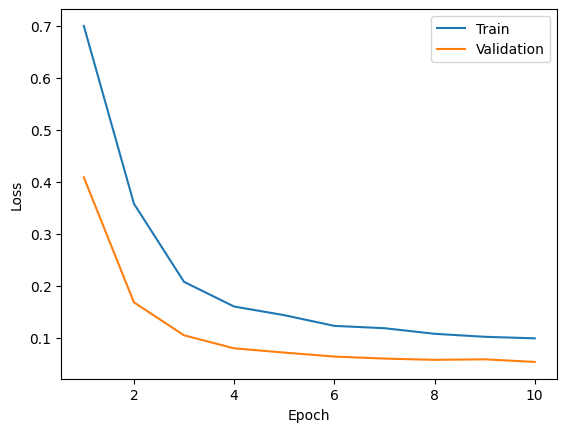

In [21]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(list(range(1, num_epochs+1)), train_loss_hist, label='Train')
plt.plot(list(range(1, num_epochs+1)), val_loss_hist, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Model performance on the hold-out test set

In [22]:
model.eval()
with torch.set_grad_enabled(False):
    test_seq = test_seq.to(device)
    test_mask = test_mask.to(device)
    
    # Forward pass
    test_outputs = model(test_seq, test_mask)

    # Probabilities and their corresponding predicted classes
    test_pred_probabilities = torch.sigmoid(test_outputs)
    test_predictions = (test_pred_probabilities > .5).int().cpu().numpy().ravel()

In [23]:
test_accuracy = accuracy_score(test_y.numpy(), test_predictions)
test_precision = precision_score(test_y.numpy(), test_predictions)
test_recall = recall_score(test_y.numpy(), test_predictions)
test_f1 = f1_score(test_y.numpy(), test_predictions)

print(f'Test acc: {test_accuracy:.3f}, \t Precision: {test_precision:.3f}, \t Recall: {test_recall:.3f}, \t F1-score: {test_f1:.3f}')

Test acc: 0.993, 	 Precision: 1.000, 	 Recall: 0.946, 	 F1-score: 0.972


# Make predictions on example text

In [24]:
sample_text = ['make sure to get the chicken out of the fridge before i get home',
               'g0 to ThIs webSite --> ph-philpost.asia/j2nds-2']

In [25]:
# Tokenize the sentences
sample_tokenized = tokenizer.batch_encode_plus(
                                                sample_text,
                                                max_length = max_seq_len,
                                                pad_to_max_length=True,
                                                truncation=True,
                                                return_token_type_ids=False
                                            )

sample_seq = torch.tensor(sample_tokenized['input_ids'])
sample_mask = torch.tensor(sample_tokenized['attention_mask'])

C:\Users\tonba\miniconda3\envs\MLprojects\Lib\site-packages\transformers\tokenization_utils_base.py:2618: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [26]:
# Make predictions
model.eval()
with torch.set_grad_enabled(False):
    sample_seq = sample_seq.to(device)
    sample_mask = sample_mask.to(device)
    
    # Forward pass
    sample_outputs = model(sample_seq, sample_mask)

    # Probabilities
    sample_pred_probabilities = torch.sigmoid(sample_outputs)
    sample_predictions = (sample_pred_probabilities > .5).int().cpu().numpy().ravel()

In [28]:
print(sample_pred_probabilities)

tensor([[0.0016],
        [0.8741]], device='cuda:0')


In [29]:
for i, (txt, pred) in enumerate(zip(sample_text, sample_predictions)):
    print(f"Original text: {txt}\nPrediction: {label_mapping[pred]}\n")

Original text: make sure to get the chicken out of the fridge before i get home
Prediction: Not Spam

Original text: g0 to ThIs webSite --> ph-philpost.asia/j2nds-2
Prediction: Spam



# Save the model

In [30]:
# Save the custom model
torch.save(model, 'model/BERT_spam_text_classifier.pth')